<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#-Forewords-" data-toc-modified-id="-Forewords--1"><span class="toc-item-num">1&nbsp;&nbsp;</span> Forewords </a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Get-Data,-Explore,-and-Process" data-toc-modified-id="Get-Data,-Explore,-and-Process-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Get Data, Explore, and Process</a></span><ul class="toc-item"><li><span><a href="#Time-Features" data-toc-modified-id="Time-Features-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Time Features</a></span></li><li><span><a href="#Locales" data-toc-modified-id="Locales-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Locales</a></span></li><li><span><a href="#Time-Features-v2" data-toc-modified-id="Time-Features-v2-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Time Features v2</a></span></li></ul></li><li><span><a href="#Training" data-toc-modified-id="Training-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training</a></span><ul class="toc-item"><li><span><a href="#Testing-the-Waters-with-Prediction-on-Single-Locale" data-toc-modified-id="Testing-the-Waters-with-Prediction-on-Single-Locale-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Testing the Waters with Prediction on Single Locale</a></span><ul class="toc-item"><li><span><a href="#Linear-Regression" data-toc-modified-id="Linear-Regression-4.1.1"><span class="toc-item-num">4.1.1&nbsp;&nbsp;</span>Linear Regression</a></span></li><li><span><a href="#Ridge-Regression-Whose-Alpha-is-Searched-by-Bayes" data-toc-modified-id="Ridge-Regression-Whose-Alpha-is-Searched-by-Bayes-4.1.2"><span class="toc-item-num">4.1.2&nbsp;&nbsp;</span>Ridge Regression Whose Alpha is Searched by Bayes</a></span></li><li><span><a href="#LightGBM,-Everyone's-Favorite-But-Not-XGBoost" data-toc-modified-id="LightGBM,-Everyone's-Favorite-But-Not-XGBoost-4.1.3"><span class="toc-item-num">4.1.3&nbsp;&nbsp;</span>LightGBM, Everyone's Favorite But Not XGBoost</a></span></li><li><span><a href="#XGBoost,-Everyone's-Favorite-But-Not-LightGBM" data-toc-modified-id="XGBoost,-Everyone's-Favorite-But-Not-LightGBM-4.1.4"><span class="toc-item-num">4.1.4&nbsp;&nbsp;</span>XGBoost, Everyone's Favorite But Not LightGBM</a></span></li><li><span><a href="#Blend" data-toc-modified-id="Blend-4.1.5"><span class="toc-item-num">4.1.5&nbsp;&nbsp;</span>Blend</a></span></li></ul></li><li><span><a href="#Training-Everything" data-toc-modified-id="Training-Everything-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Training Everything</a></span></li></ul></li></ul></div>

<h1> Forewords </h1>

Hi, welcome to my submission! Nicholas here, a budding Data Scientist looking for entry-level data science jobs, with background in Mathematics-slash-Statistics and enjoyed some intense competitive maths in HS. Active musician but currently disrupted by my quest in learning AI stuff. What a disruptive technology indeed. Anyway, to keep it interesting (checking out others' codes are a nightmare!) and well-documented, I have decided to take this submission into Jupyter notebook (which you see right now) and added some bad jokes to showcase my (un)creativity.

Sorry for the cheeky filename. Cannot help myself!

Lastly, hope you enjoy checking my work out. At least if I don't score well, I entertain well. Cue *that* meme.

![Honest work!](../imgs/honest.jpg)

# Imports

In [137]:
# Import the data science trinity ;)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Geohash library downloaded from: https://github.com/hkwi/python-geohash
import geohash
import datetime
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import expon
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import pickle
import warnings

warnings.filterwarnings("ignore")

# Get Data, Explore, and Process
This submission will focus on getting the important features. I am a firm believer of simple and fast models plus actually predictive features will solve most problems elegantly. Throughout this submission, I am trying my almost best to reduce the time complexities of the processes. I am going for my graduation trip to Korea from 7th to 16th June, wish me fun; hence not too much time for me to tinker too much of that, or excessive hyperparameter tuning.

Edit (16th June): It was really fun! Hit me up for recommendations.

In [107]:
df = pd.read_csv('../data/raw/training.csv')
df.sample(3)

,geohash6,day,timestamp,demand
835238,qp0djm,39,1:30,0.043807
913422,qp09jp,39,14:0,0.054567
4032133,qp0djm,21,2:15,0.028690


## Time Features

In [108]:
hrs = np.array([int(x.split(':')[0]) for x in df['timestamp']])
mns = np.array([int(x.split(':')[1]) for x in df['timestamp']])

Datetime indexing takes a lot of time, so we will use timestep indexing instead.

In [109]:
df['timestep'] = [int(x) for x in 96*df['day']+4*hrs+mns/15-96]
df.set_index('timestep', inplace=True)

df['hr'] = [str(x) for x in hrs]
df.drop(columns=['timestamp','day'], inplace=True)
df.sample(3)

,geohash6,demand,hr
timestep,,,
2158,qp0d49,0.250804,11
4420,qp093r,0.078671,1
2916,qp09db,1.000000,9


## Locales
_"Let's call it **locale**, for lack of better word and lack of effort to look for better words." - me_

In [110]:
# Get all possible geohash values
gh = list(set(df['geohash6'].values))
coords = {x:geohash.decode(x) for x in gh}

df['lat'] = [coords[x][0] for x in df['geohash6']]
df['lon'] = [coords[x][1] for x in df['geohash6']]

print("# different coordinates: {}".format(len(gh)))

lats = [x[0] for x in list(coords.values())]
lons = [x[1] for x in list(coords.values())]

print("# different longitudes: {}".format(len(set(lons))))
print("# different latitudes: {}".format(len(set(lats))))

# different coordinates: 1329
# different longitudes: 36
# different latitudes: 46


Because 1329 is not too different to 36x46, the coordinate grid is quite dense. We will replace the coordinate pairs to _locales_ of size 0.05x0.05 degrees squared. The method below is by far the most time-efficient!

In [111]:
lsize = 0.05
df['locale'] = [str(int(x))+str(int(y)) for x,y in zip((df['lat']-min(lats))/lsize, (df['lon']-min(lons))/lsize)]

locales = list(set(df['locale'].values))
df = df.drop(columns = ['lat', 'lon'])

Fill gaps in time with hourly mean* of every geohash area. In case there is consistently no data at every hour of day, we impute 0.

Note: Will be better if you can make this faster. I have noticed that splitting into locales first brings significant improvement of speed.

**I know this is a crime for using data that is to be used as test data for feature engineering, but if the training set and test set comes from the same distribution(therefore same statistical properties e.g. mean), this will not matter since we are using exactly the mean! This will however restrict us to split the train-test set randomly. We could also use the mean for the last certain window length but this time I will leave it at that.*

***
***

Oh just thought of possibly good features too: Moving averages - both standard and exponentially-weighted, and logical choices of previous demand to capture trends, autoregression, and time dependencies.

On EWMA: I mean, I could have used Bayesian optimization to find the theoretically justified _com_ parameter, perhaps to maximize the total autocorrelation of the moving averages to the actual time series up to lag 5, but a little experimentation with the numbers say that the number below works pretty decently. I do not have too much time! <br>
On EMA: Just go trigger happy with the window length.

In [112]:
# Get maximum timestep
maxin = max(np.array(df.index))

shut_your_traps = False

dfs = []
count = 0
for l in locales:
    dff = df[df['locale'] == l]
    ghs = list(set(dff['geohash6']))
    for g in ghs:
        dfff = dff[dff['geohash6']==g].reindex([x for x in range(maxin)])
        dfff['hr'] = [int(x) for x in np.array(dfff.index)%96/4]
        dfff['locale'] = l
        dfff['geohash6'] = g
        # All the 5 next timesteps after, but the day before
        dfff['prev'] = dfff['demand'].shift(96)
        # Here lies the possible crime - filling empty values with mean demand of geohash area - brace yourselves
        dfff['demand'] = dfff.groupby(['hr'])['demand'].apply(lambda x: x.fillna(x.mean()))
        dfff['demand'].fillna(0, inplace = True)
        # Moving averages
        dfff['ewm'] = dfff['demand'].ewm(com=0.35).mean()
        dfff['ma4'] = dfff['demand'].rolling(4).mean()
        dfff['ma12'] = dfff['demand'].rolling(12).mean()
        dfff['ma24'] = dfff['demand'].rolling(24).mean()
        dfs.append(dfff)
        count+=1
        if count%200==0:
            print("{} geohashes done.".format(count))
        if (count%500==0) and (not shut_your_traps):
            print("Doesn't logs like this make waiting much more bearable?")

200 geohashes done.
400 geohashes done.
Doesn't logs like this make waiting much more bearable?
600 geohashes done.
800 geohashes done.
1000 geohashes done.
Doesn't logs like this make waiting much more bearable?
1200 geohashes done.


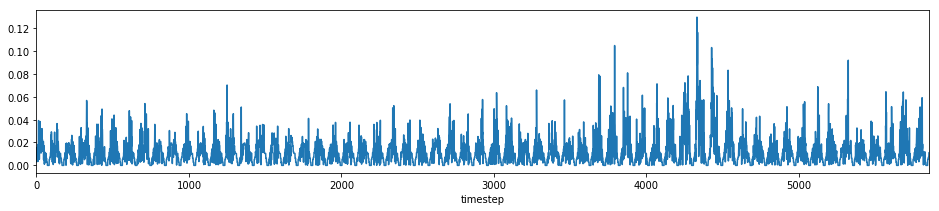

In [113]:
# Sample imputed data from a single geohash area
dfs[42]['demand'].plot(figsize = (16,3));

Concatenate back all the imputed data. Now we have 1329(geohashes)x5855(timesteps), almost 8 million rows. Whoa.

Also, at this point let's say we don't need geohash anymore.

In [114]:
df = pd.concat(dfs)
df.drop(columns=['geohash6'], inplace=True)

Another possible set of features:
- Mean of locale
- Standard deviation of locale

To see if the area is relatively busy/quiet within the locale. Again, this might be a crime for some of you. Sorry, I am new to this.

In [115]:
df['loc_mean'] = df.groupby(['locale','hr'])['demand'].transform('mean')
df['loc_std'] = df.groupby(['locale','hr'])['demand'].transform('std')

## Time Features v2

Add hour, week, DoW (day of week), and sin and cos to represent time distance (as time of day is cyclical).

Fun Fact: Running all that stuff above took me and my puny laptop 90-150 seconds (excluding imports). But I would give anything for a good _feature engineering_. I guess it's time for me to start learning PySpark seriously.

Fun Fact 2: At this point I almost succumbed to the urge to at least try a simple, untuned XGBoost model. Self-restraint.

In [116]:
day = np.array([int(x/96) for x in df.index])
brac = np.array([x%96 for x in df.index])
df['wk'] = [int(x/7) for x in day]
for i in range(1,7):
    df['d'+str(i)] = (day%7 == i)

df['sin'] = np.sin(brac*np.pi/48)
df['cos'] = np.cos(brac*np.pi/48)

df = 1*pd.get_dummies(df, columns=['hr'], prefix_sep='')

Always hated this moment where I have to sacrifice some data.<br>
Like dramatic movies, someone has to die in the end. Oh well.

In [117]:
df.dropna(inplace=True)

# Training
Probably it's just me that thinks making 30+ different models for the submission is a good idea. Certainly doable with your huge computing cluster but not for me and my puny laptop (training everything made it crash due to memory error). Anyway, the plan is to train, blend (forget about meta-model stacking as it is heavy and overfits often), and pickle the models.

The popular way to evaluate may include KFold-ing the whole dataset, but since I am splitting it to multiple subsets, I will just do standard train-test split and evaluate with models with the area-specific hyperparameters.

Training uses current conditions to predict 5 steps into the future.

In [118]:
df_byloc = {}
for l in locales:
    df_byloc[l] = df[df['locale']==l].drop(columns=['locale'])

In [119]:
dloc = df_byloc[locales[0]]
target = []
for i in range(5):
    target.append(dloc.iloc[:,0].shift(-i-1))
target = pd.concat(target, axis=1)[:-5]
xtrain, xtest, ytrain, ytest = train_test_split(dloc.iloc[:-5,:], target,
                                                test_size=0.1, shuffle = True,
                                                random_state = 42)
sc = MinMaxScaler(feature_range=(0,1))
xtrain = sc.fit_transform(xtrain)
xtest = sc.transform(xtest)

## Testing the Waters with Prediction on Single Locale

### Linear Regression
Just for the baseline/entrée and quick training time, never expected it to do well.

In [120]:
lr = RegressorChain(LinearRegression())
lr.fit(xtrain,ytrain)
pred_lr = lr.predict(xtest)
r2_score(ytest, pred_lr, multioutput='variance_weighted')

0.75645731542439

Modest.

### Ridge Regression Whose Alpha is Searched by Bayes
![Thomas](../imgs/bayes.jpg) There really is no reason to put his picture here, but I admire him! Anyway, I like to keep the hyperparameters as is and let Bayes do his magic.

In [121]:
br = RegressorChain(BayesianRidge(), cv=3)
br.fit(xtrain,ytrain)
pred_br = br.predict(xtest)
r2_score(ytest, pred_br, multioutput='variance_weighted')

0.7565683680597188

Not better.

### LightGBM, Everyone's Favorite But Not XGBoost
I have a good feeling that tree-based models will work wonders. Let's start with some of my WildInstinct™ hyperparameters (also based on the little experience that I have).

In [122]:
lgb = RegressorChain(LGBMRegressor(n_estimators=200,
                                   num_leaves=63,
                                   max_depth=6,
                                   subsample=0.8,
                                   colsample_bytree=0.8,
                                   reg_alpha=0.1,
                                   learning_rate=0.3,
                                   n_jobs=-1))
lgb.fit(xtrain,ytrain)
pred_lgb = lgb.predict(xtest)
r2_score(ytest, pred_lgb, multioutput='variance_weighted')

0.7890608550449413

In [123]:
np.sqrt(((ytest-pred_lgb)**2).mean())

demand    0.021539
demand    0.023453
demand    0.023620
demand    0.024585
demand    0.024391
dtype: float64

Is that an improvement?! Ridiculous!

### XGBoost, Everyone's Favorite But Not LightGBM
WildInstinct™ on play again!

In [124]:
xgb = RegressorChain(XGBRegressor(n_estimators=200,
                                  n_jobs=-1,
                                  max_depth=5,
                                  colsample_bylevel=0.6,
                                  colsample_bytree=0.8,
                                  reg_alpha=0.1))
xgb.fit(xtrain,ytrain)
pred_xgb = xgb.predict(xtest)
r2_score(ytest, pred_xgb, multioutput='variance_weighted')

0.7890222812564784

I could spam all the methods I know, but I think that's all for today.

### Blend
Just because it performs better!

In [125]:
pred_bld = (pred_lgb+pred_xgb)/2
r2_score(ytest, pred_bld, multioutput='variance_weighted')

0.793837887474277

## Training Everything
I will use only LightGBM for this, as other methods either don't work as well, or inference/tuning takes too long. Also remove locales with **less than 5000 samples**, as with 96 different time buckets in a day, it is not enough to make a powerful inference on the behaviour of the data.

In [138]:
for l in locales:
    dloc = df_byloc[l]
    if dloc.shape[0]<5000:
        locales.remove(l)
        print("Removed locale {}, only has {} data samples".format(l,dloc.shape[0]))

Removed locale 40, only has 2195 data samples


<b>WARNING!</b>

Training takes super long.

In [141]:
r2s = []
rmses = []
cou = 0
param_dist = {'base_estimator__colsample_bytree': [x/10 for x in range(6,10)],
              'base_estimator__learning_rate': [0.1, 0.3],
              'base_estimator__num_leaves': [2**x-1 for x in range(4,7)],
              'base_estimator__reg_alpha': expon(scale = 0.1),
              'base_estimator__reg_lambda': expon(scale = 0.01),
              'base_estimator__subsample': [x/10 for x in range(6,10)]}

for l in locales:
    dloc = df_byloc[l]
    target = []
    for i in range(5):
        target.append(dloc.iloc[:,0].shift(-i-1))
    target = pd.concat(target, axis=1)[:-5]
    xtrain, xtest, ytrain, ytest = train_test_split(dloc.iloc[:-5,:], target,
                                                    test_size=0.1, shuffle = True,
                                                    random_state = 42)
    sc = MinMaxScaler(feature_range=(0,1))
    xtrain = sc.fit_transform(xtrain)
    xtest = sc.transform(xtest)
    
    # Can use more estimators and BayesSearchCV here, so that every locale gets a different
    # hyperparameter based on our prior, but takes too much time. I have to use my laptop for something else!
    rchain = RegressorChain(LGBMRegressor(n_estimators=200,
                                          num_leaves=63,
                                          max_depth=6,
                                          subsample=0.8,
                                          colsample_bytree=0.8,
                                          reg_alpha=0.1,
                                          learning_rate=0.3,
                                          n_jobs=-1))
    lgb = RandomizedSearchCV(rchain,
                             param_dist,
                             n_iter=10,
                             n_jobs=-1,
                             cv=3)
    lgb.fit(xtrain,ytrain)
    pred_lgb = lgb.predict(xtest)
    r2 = r2_score(ytest, pred_lgb)
    r2s.append(r2)
    rmse = np.sqrt(mean_squared_error(ytest, pred_lgb))
    rmses.append(rmse)
    cou += 1
    if cou%3 == 0:
        print("Done {}/{}".format(cou, len(locales)))

Done 3/36
Done 6/36
Done 9/36
Done 12/36
Done 15/36
Done 18/36
Done 21/36
Done 24/36
Done 27/36
Done 30/36
Done 33/36
Done 36/36


In [142]:
r2df = pd.DataFrame(r2s)
r2df.describe()

,0
count,36.000000
mean,0.836733
std,0.094177
min,0.596200
25%,0.765361
50%,0.849126
75%,0.920602
max,0.969613


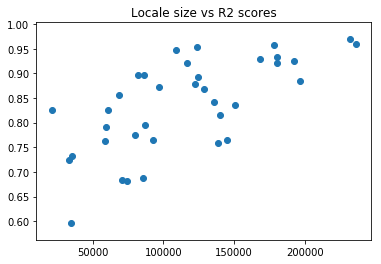

In [143]:
plt.scatter([df_byloc[x].shape[0] for x in locales], r2s)
plt.title('Locale size vs R2 scores');

Generally locales with more samples allows the model to perform better. This is good since it makes my score better!